In [1]:
using ModelingToolkit, Plots, DifferentialEquations
using OrdinaryDiffEq
using Symbolics
# using ThermalSystem_Models
# TSM = ThermalSystem_Models
# TSMD = TSM.Dynamics
# MTK = ModelingToolkit

## Basic tests

#### Ports

In [117]:
#= Ports =#
@variables t
const D = Differential(t)

function thermal_dof(name)
    @variables T(t)=300  [description = "Temperature (K)"]
    @variables ds(t)=0.0 [description = "Entropy Flow Rate = dS/dt W/K"]
    ODESystem(Equation[], t,[T,ds],[]; name = name)
end

function mechanical_dof(name)
    @variables P(t)=101325  [description = "Pressure, (Pa)"]
    @variables dv(t)=0.0    [description = "Volume flow rate, m^3/s, = v*A"]
    ODESystem(Equation[], t,[T,ds],[]; name = name)
end

function energy_dof(name)
    @variables dE(t) = 0 [description = "Energy Rate (W)"]
    ODESystem(Equation[], t,[dE],[]; name = name)
end

function signal_dof(name)
    @variables sig(t) = 0   [description = "Signal (unitless)"]
    ODESystem(Equation[], t,[sig],[]; name = name)
end


signal_dof (generic function with 1 method)

#### Components

In [109]:
# Energy to thermal dof transformer
function e2t_transformer(name)
    e = energy_dof(:e)  # (+) e.De = energy into the system
    q = thermal_dof(:q)
    eqs = [e.dE ~ -q.T * q.ds]
    compose(ODESystem(eqs, t,[],[]; name = name),e,q)
end

# constant energy flow source
function constantEnergyFlowSource(name; eflow)
    e = energy_dof(:e)
    eqs = [e.dE ~ -eflow]
    compose(ODESystem(eqs,t,[],[]; name = name),e)
end

function thermalGround(name; temperature = 300)
    q = thermal_dof(:q)
    eqs = [q.T ~ temperature]
    compose(ODESystem(eqs, t,[],[]; name = name), q)
end

function pointMass(name; mass = 1.0, specific_heat = 10)
    @parameters m=mass cp=specific_heat
    C = m * cp
    q = thermal_dof(:q);
    eqs = [D(q.T) ~ (q.T * q.ds)/ C]
    compose(ODESystem(eqs, t, [], [m,cp],name = name), q)
end

function thermalResistor(name; UA = 1.0)
    @parameters R=1/UA

    qi = thermal_dof(:qi)
    qo = thermal_dof(:qo)

    eqs = [ qi.T*qi.ds ~ 1/R * (qi.T - qo.T),
            0 ~ qo.T*qo.ds +  qi.T*qi.ds]
    compose(ODESystem(eqs, t, [], [R], name = name), qi,qo)
end


function eConnect(pins...)
    eqns = [sum(pin -> pin.dE, pins) ~ 0.0]
end

function thermalConnect(pins...)
    eqs = [
        sum(pin -> pin.ds, pins) ~ 0.0, # Entropy flow rate
    ]
    for pin in pins[2:end]
        push!(eqs, pins[1].T ~ pin.T)   # p_1 = p_2, p_1 = p_3,...
    end
    eqs
end

thermalConnect (generic function with 2 methods)

 Basic Heating Case
 
Unconstrained heating, adding energy to system without removal

In [ ]:
src             = constantEnergyFlowSource(:src; eflow = 100)
transformer     = e2t_transformer(:transformer)
Rtherm          = thermalResistor(:Rtherm)
mass            = pointMass(:mass)

#= heating only =#
connections =   vcat(eConnect(src.e,transformer.e),
                    thermalConnect(transformer.q,mass.q))

sysbuild = compose(ODESystem(connections, t, name = :sysbuild),
                    [src,transformer,mass])
                    
sys = structural_simplify(sysbuild)
prob = ODEProblem(sys,[],(0,10))
sol = solve(prob)
plot(sol[sys.mass.q.T])

Basic Cooling Case
Mass at initial temperature connected by resistance to environement

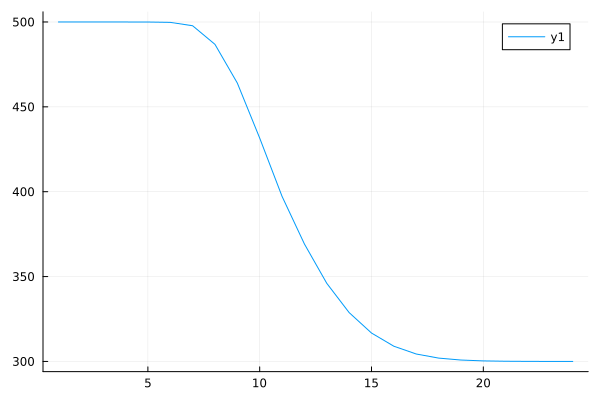

In [110]:
#= cooling only =#
Rtherm          = thermalResistor(:Rtherm)
mass            = pointMass(:mass)
Tground         = thermalGround(:Tground; temperature = 300)

subsys = [mass, Rtherm, Tground]

connections =   vcat(thermalConnect(mass.q,Rtherm.qi),
                    thermalConnect(Rtherm.qo,Tground.q))

sysbuild = compose(ODESystem(connections, t, name = :sysbuild), subsys...)             
sys = structural_simplify(sysbuild)
u0 = [sys.mass.q.T => 500]
prob = ODEProblem(sys,u0,(0,100))
sol = solve(prob)
plot(sol[sys.mass.q.T])

Full case
Energy applied to a mass object that has a resistance connected to the environment

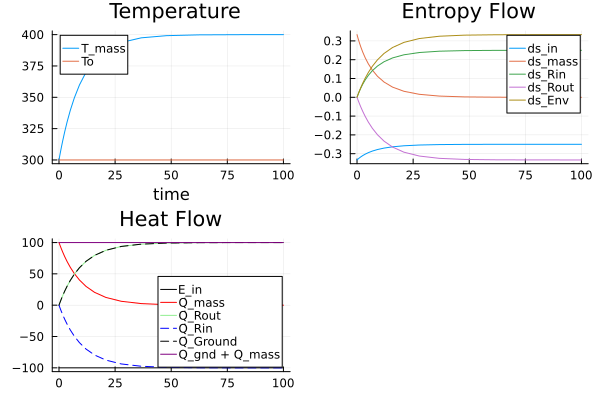

In [106]:
src             = constantEnergyFlowSource(:src; eflow = 100)
transformer     = e2t_transformer(:transformer)
Rtherm          = thermalResistor(:Rtherm)
mass            = pointMass(:mass)
Tground         = thermalGround(:Tground; temperature = 300)

subsys = [src, transformer, Rtherm, mass, Tground]

connections =   vcat(eConnect(src.e, transformer.e),
                    thermalConnect(transformer.q, mass.q, Rtherm.qi),
                    thermalConnect(Rtherm.qo,Tground.q))

sysbuild = compose(ODESystem(connections, t, name = :sysbuild), subsys...)
                    
sys = structural_simplify(sysbuild)

prob = ODEProblem(sys,[],(0,100))
sol = solve(prob)

gr()
Tfig = plot(sol.t,sol[sys.mass.q.T], label = "T_mass", title =" Temperature")
plot!(Tfig,sol.t,sol[sys.Rtherm.qo.T], label = "To")
xlabel!(Tfig,"time")

Sfig = plot(sol.t,sol[sys.transformer.q.ds],label = "ds_in",  title ="Entropy Flow")
plot!(Sfig, sol.t,sol[sys.mass.q.ds],label = "ds_mass")
plot!(Sfig, sol.t, sol[sys.Rtherm.qi.ds], label = "ds_Rin")
plot!(Sfig, sol.t, sol[sys.Rtherm.qo.ds], label = "ds_Rout")
plot!(Sfig, sol.t, sol[sys.Tground.q.ds], label = "ds_Env")
xlabel!(Tfig,"time")

Pfig = plot( sol.t, sol[sys.src.e.dE], label = "E_in", linecolor = :black, linestyle = :solid, title = "Heat Flow")
plot!(Pfig, sol.t, sol[sys.mass.q.ds] .* sol[sys.mass.q.T], label = "Q̇_mass", linecolor = :red, linestyle = :solid)
plot!(Pfig, sol.t, sol[sys.Rtherm.qi.ds] .* sol[sys.Rtherm.qi.T], label = "Q̇_Rout", linecolor = :lightgreen, linestyle  = :solid)
plot!(Pfig, sol.t, sol[sys.Rtherm.qo.ds] .* sol[sys.Rtherm.qo.T], label = "Q̇_Rin", linecolor = :blue, linestyle  = :dash)
plot!(Pfig, sol.t, sol[sys.Tground.q.ds] .* sol[sys.Tground.q.T], label = "Q̇_Ground", linecolor = :black, linestyle  = :dash)
plot!(Pfig, sol.t, sol[sys.mass.q.ds] .* sol[sys.mass.q.T] .+ sol[sys.Tground.q.ds] .* sol[sys.Tground.q.T], label = "Q_gnd + Q_mass", linecolor = :purple)
xlabel!(Tfig,"time")
p = plot(Tfig,Sfig,Pfig)

Double mass equilibrium


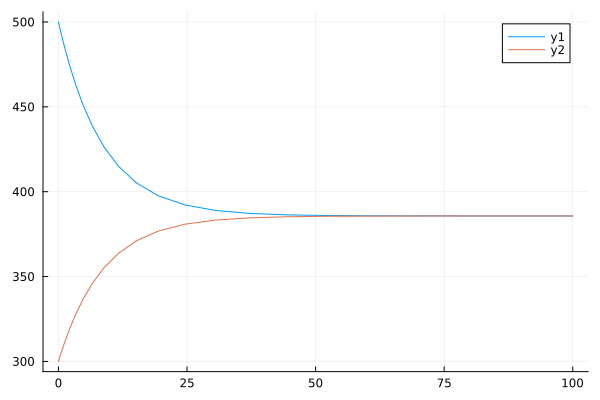

In [114]:
mass1 = pointMass(:mass1; mass = 100, specific_heat = 15)
mass2 = pointMass(:mass2; mass = 200, specific_heat = 10)
Rtherm = thermalResistor(:Rtherm; UA = 100)

connections = vcat(thermalConnect(mass1.q,Rtherm.qi),
                    thermalConnect(Rtherm.qo,mass2.q));

subsys = [mass1,mass2,Rtherm]

sysbuild = compose(ODESystem(connections, t, name = :sysbuild), subsys...)
                    
sys = structural_simplify(sysbuild)

u0 = [mass1.q.T => 500,
        mass2.q.T => 300]

prob = ODEProblem(sys,u0,(0,100))
sol = solve(prob)


pp=plot(sol.t,sol[mass1.q.T])
plot!(pp,sol.t,sol[mass2.q.T])


1×5 Matrix{Symbol}:
 :solid  :dash  :dot  :dashdot  :dashdotdot

#### Generalized approach from Veinik AI

In [ ]:
# Basic electric components
@variables t
const D = Differential(t)

# abstract type fomom # form of motion of matter, Veinik A. I.

mutable struct fomom
    X::Num   # generalized force
    x::Num   # generalized charge
end

mutable struct thermodynamic_system
    foms::Vector{fomom}
end

# dofs
function mechanical_dof()
    @variables P(t)=101325 V(t)=1.0 # pressure and volume
    fomom(P,V)
end

function thermal_dof()
    @variables T(t) = 300 S(t)=1.0  # temperature entropy
    fomom(T,S)
end

function kinetic_def()
    @variables V(t) P(t)            # velocity and momentum
    fomom(V,P)
end

# functions
function generalized_work(dof::fomom)
    @variables W(t)
    eqn = [D(W) ~ dof.X * D(dof.x)]
end

function specific_charge(dof::fomom)
    @variables G(t) # system mass or weight
    specific_c = parse_expr_to_symbolic.(Symbol(lowercase(string(dof.x))), (Main,)) 
    vars = union(ModelingToolkit.vars.(eqs[1])...)
    eqn = [vars[1] ~ dof.x/G]
end

# generaized equation of state for 1 dof system,   X = x * X
function EOS_1d(dof::fomom, A)
    eqn = [dof.X ~ A * dof.x]   
end

md = mechanical_dof()
generalized_work(md)
specific_charge(md)

In [ ]:


function Ground(; name)
    @named g = Pin()
    eqs = [g.v ~ 0]
    compose(ODESystem(eqs, t, [], [], name = name), g)
end

@connector function HeatPort(; name)
    @variables T(t)=293.15 Q_flow(t)=0.0 [connect = Flow]
    ODESystem(Equation[], t, [T, Q_flow], [], name = name)
end

function ConstantVoltage(; name, V = 1.0)
    val = V
    @named p = Pin()
    @named n = Pin()
    @parameters V = V
    eqs = [V ~ p.v - n.v
            0 ~ p.i + n.i]
    compose(ODESystem(eqs, t, [], [V], name = name), p, n)
end



function HeatingResistor(; name, R = 1.0, TAmbient = 293.15, alpha = 1.0)
    @named p = Pin()
    @named n = Pin()
    @named h = HeatPort()
    @variables v(t) RTherm(t)
    @parameters R=R TAmbient=TAmbient alpha=alpha
    eqs = [RTherm ~ R * (1 + alpha * (h.T - TAmbient))
        v ~ p.i * RTherm
        h.Q_flow ~ -v * p.i # -LossPower
        v ~ p.v - n.v
        0 ~ p.i + n.i]
    compose(ODESystem(eqs, t, [v, RTherm], [R, TAmbient, alpha],
            name = name), p, n, h)
end

function HeatCapacitor(; name, rho = 8050, V = 1, cp = 460)
    @parameters rho=rho V=V cp=cp
    C = rho * V * cp
    @named h = HeatPort()
    eqs = [
        D(h.T) ~ h.Q_flow / C,
    ]
    compose(ODESystem(eqs, t, [], [rho, V, cp],
            name = name), h)
end

function Capacitor(; name, C = 1.0)
    @named p = Pin()
    @named n = Pin()
    @variables v(t) = 0.0
    @parameters C = C
    eqs = [v ~ p.v - n.v
        0 ~ p.i + n.i
        D(v) ~ p.i / C]
    compose(ODESystem(eqs, t, [v], [C],
            name = name), p, n)
end

function parallel_rc_model(i; name, source, ground, R, C)
    resistor = HeatingResistor(name = Symbol(:resistor, i), R = R)
    capacitor = Capacitor(name = Symbol(:capacitor, i), C = C)
    heat_capacitor = HeatCapacitor(name = Symbol(:heat_capacitor, i))

    rc_eqs = [connect(source.p, resistor.p)
        connect(resistor.n, capacitor.p)
        connect(capacitor.n, source.n, ground.g)
        connect(resistor.h, heat_capacitor.h)]

    compose(ODESystem(rc_eqs, t, name = Symbol(name, i)),
        [resistor, capacitor, source, ground, heat_capacitor])
end

In [ ]:

@variables t
@connector Pin begin
    v(t)
    i(t), [connect = Flow]
end

@mtkmodel Ground begin
    @components begin
        g = Pin()
    end
    @equations begin
        g.v ~ 0
    end
end

@mtkmodel OnePort begin
    @components begin
        p = Pin()
        n = Pin()
    end
    @variables begin
        v(t)
        i(t)
    end
    @equations begin
        v ~ p.v - n.v
        0 ~ p.i + n.i
        i ~ p.i
    end
end

@mtkmodel Resistor begin
    @extend OnePort()
    @parameters begin
        R = 1.0 # Sets the default resistance
    end
    @equations begin
        v ~ i * R
    end
end

D = Differential(t)

@mtkmodel Capacitor begin
    @extend OnePort()
    @parameters begin
        C = 1.0
    end
    @equations begin
        D(v) ~ i / C
    end
end

@mtkmodel ConstantVoltage begin
    @extend OnePort()
    @parameters begin
        V = 1.0
    end
    @equations begin
        V ~ v
    end
end

@mtkmodel RCModel begin
    @components begin
        resistor = Resistor(R = 1.0)
        capacitor = Capacitor(C = 1.0)
        source = ConstantVoltage(V = 1.0)
        ground = Ground()
    end
    @equations begin
        connect(source.p, resistor.p)
        connect(resistor.n, capacitor.p)
        connect(capacitor.n, source.n)
        connect(capacitor.n, ground.g)
    end
end

@mtkbuild rc_model = RCModel(resistor.R = 2.0)
u0 = [
    rc_model.capacitor.v => 0.0,
]
prob = ODEProblem(rc_model, u0, (0, 10.0))
sol = solve(prob)
plot(sol)